# Installing the libraries

In [ ]:
!apt-get install python3-pydot graphviz

In [ ]:
#hide_output

!pip install fastai2
!pip install graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn
!pip install azure-cognitiveservices-search-imagesearch
!pip install utils
!pip install Pillow
!pip install webp
!pip install ipywidgets
!pip install Voila
!pip install voila-debug


In [ ]:
#hide
!jupyter serverextension enable voila --sys-prefix


In [ ]:
#hide
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
#hide_output
!git clone https://github.com/fastai/course-v4 'drive/My Drive/course-v4'


In [7]:
#hide
from fastai2.vision.all import *
from fastai2 import *
from utils import *
from fastai2.vision.widgets import *

In [8]:
#hide
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype

# Collecting the data

In [9]:
#hide
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

In [10]:
#hide
key = '173e7aa99dc34bdeabacd319ac5c4a92'


In [11]:
#hide
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [ ]:
#hide
results = search_images_bing(key, 'girls kids')
ims = results.attrgot('content_url')
len(ims)

In [ ]:
#hide
ims[0]


In [14]:
#hide
kids= 'girl', 'boy'


In [15]:
#hide
path = Path('media')
if not path.exists():
    path.mkdir()
    for o in kids:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} kids')
        download_images(dest, urls=results.attrgot('content_url'))

In [ ]:
#hide
fns = get_image_files(path)
fns

In [ ]:
#hide
fns[0]


In [ ]:
#hide_output
to_see= 'media/girls/00000000.jpg'
download_url(fns[0], to_see)
im = Image.open(to_see)
im.to_thumb(128,128)

In [19]:
#hide
from PIL import Image

In [ ]:
#hide_output
failed = verify_images(fns)
failed

In [21]:
#hide
failed.map(Path.unlink);


# Showing the data and the labels

In [22]:
#hide
media_data = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [23]:
#hide
dls= media_data.dataloaders(path)


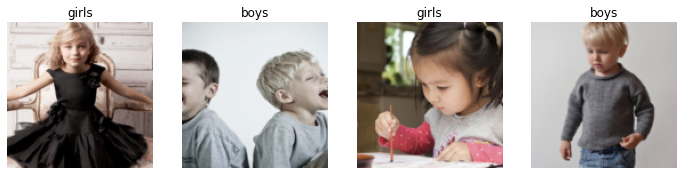

In [24]:
#hide_output
dls.valid.show_batch(max_n=4, nrows=1)


# Resizing the data

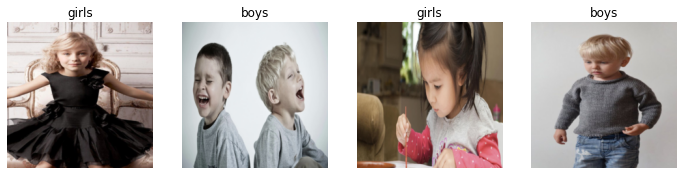

In [25]:
#hide_output
media_data = media_data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = media_data.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# Training 

In [26]:
#hide_output
learn= cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time
0,1.228942,2.672254,0.471429,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.698004,1.433195,0.428571,00:04
1,0.682279,0.373139,0.214286,00:04
2,0.569685,0.243266,0.114286,00:04
3,0.499257,0.221967,0.114286,00:04


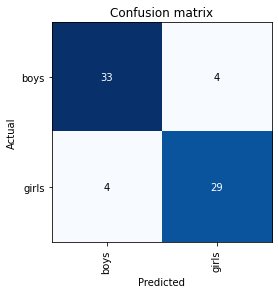

In [27]:
#hide_output
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

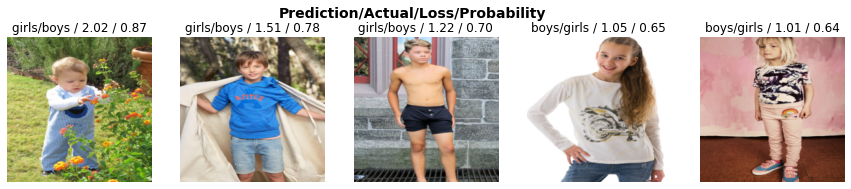

In [28]:
#hide_output
interp.plot_top_losses(5, nrows=1)


In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [31]:
#hide
learn.export()


# Prediction

In [ ]:
#hide_output
path = Path()
path.ls(file_exts='.pkl')

In [33]:
#hide
learn_inf = load_learner(path/'export.pkl', cpu=True)


In [ ]:
#hide_output
learn_inf.predict('media/girls/00000000.jpg')


In [ ]:
#hide_output
learn_inf.dls.vocab


In [36]:
#hide
from IPython.display import display


In [61]:
lbl_pred = widgets.Label()
out_pl = widgets.Output()


In [59]:
btn_run = widgets.Button(description='Classify')


In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
btn_upload = widgets.FileUpload()


In [53]:
VBox([widgets.Label('Am I represented?'), 
      btn_upload, btn_run, out_pl, lbl_pred])